In [2]:
import pymongo
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from github import Github
from scripts import MONGO_URL, GITHUB_TOKENS
from scripts.analysis import data

for path in matplotlib.font_manager.findSystemFonts():
    f = matplotlib.font_manager.get_font(path)
    if f.family_name == "Times New Roman":
        matplotlib.font_manager.fontManager.addfont(path)
        prop = matplotlib.font_manager.FontProperties(fname=path)
        plt.rcParams["font.family"] = "serif"
        plt.rcParams["font.sans-serif"] = prop.get_name()

In [4]:
repo_name = "gqylpy/funccache"
stars = data.get_stars_by_month_all()
this_repo = stars[stars.repo == repo_name][["month", "n_stars", "n_stars_fake"]]
first, last = this_repo.iloc[0].month, this_repo.iloc[-1].month
for month in pd.date_range(first, last, freq="MS"):
    if month.strftime("%Y-%m") not in list(this_repo.month):
        this_repo = pd.concat(
            [
                this_repo,
                pd.DataFrame(
                    {
                        "month": [month.strftime("%Y-%m")],
                        "n_stars": 0,
                        "n_stars_fake": 0,
                    }
                ),
            ]
        )
this_repo = this_repo.sort_values("month").set_index("month").cumsum().reset_index()

this_repo

,month,n_stars,n_stars_fake
0,2023-05,2.0,2.0
1,2023-06,2.0,2.0
2,2023-07,2.0,2.0
3,2023-08,3.0,2.0
4,2023-09,3.0,2.0
5,2023-10,3.0,2.0
6,2023-11,3.0,2.0
7,2023-12,3.0,2.0
8,2024-01,3.0,2.0
9,2024-02,3.0,2.0


In [9]:
with pymongo.MongoClient(MONGO_URL) as client:
    results = (
        pd.DataFrame(
            list(
                map(
                    lambda x: {
                        "repo": x["_id"]["repo_name"],
                        "month": x["_id"]["month"],
                        "n_stars": x["n_stars"],
                    },
                    client.fake_stars.sample_repos.aggregate(
                        [
                            {"$match": {"type": "WatchEvent"}},
                            {
                                "$group": {
                                    "_id": {
                                        "repo_name": "$repo_name",
                                        "month": {"$substr": ["$created_at", 0, 7]},
                                    },
                                    "n_stars": {"$sum": 1},
                                }
                            },
                        ]
                    ),
                )
            )
        )
        .sort_values(by=["repo", "month"])
        .reset_index(drop=True)
    )
results.to_csv("data/sample_repo_stars_by_month.csv", index=False)

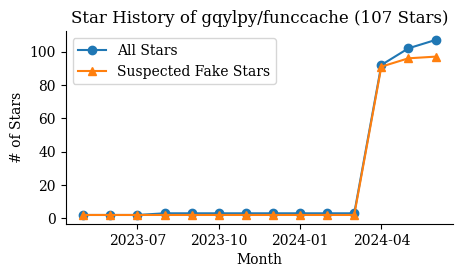

In [5]:
fig, ax = plt.subplots(figsize=(5, 2.5))
this_repo[["month", "n_stars"]].plot(
    x="month",
    color="C0",
    ax=ax,
    marker="o",
)
this_repo[["month", "n_stars_fake"]].plot(
    x="month",
    color="C1",
    ax=ax,
    marker="^",
)
ax.set_title(f"Star History of {repo_name} ({int(this_repo["n_stars"].iloc[-1])} Stars)")
ax.set_ylabel("# of Stars")
ax.set_xlabel("Month")
ax.set_xticks(range(2, len(this_repo), 3))
ax.set_xticklabels(this_repo["month"].iloc[2::3])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(["All Stars", "Suspected Fake Stars"])
fig.savefig("plots/example-timeline.png", bbox_inches="tight", dpi=300)

In [13]:
with pymongo.MongoClient(MONGO_URL) as client:
    collection = client.fake_stars.clustered_stars
    stargazers = pd.DataFrame(collection.find({"repo": repo_name}))
github = Github(GITHUB_TOKENS[0])
actors = []
for actor in tqdm(stargazers[stargazers.clustered].actor):
    info = github.get_user(actor)
    actors.append(
        {
            "id": actor,
            "n_events": info.get_events().totalCount,
            "n_stars": info.get_starred().totalCount,
            "n_repos": info.get_repos().totalCount,
        }
    )
actors = pd.DataFrame(actors)
actors.head()

100%|██████████| 97/97 [02:16<00:00,  1.40s/it]


,id,n_events,n_stars,n_repos
0,CndAir,86,635,67
1,LedArx,129,948,81
2,LujiaJin,291,1574,47
3,ent-ncc1701,2,326,13
4,seasonstaris,85,669,3


In [14]:
actors.to_csv("temp.csv", index=False)